In [10]:
from SimuSamp.functions.load.SpatDat import SpatDat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#
from statsmodels.nonparametric.smoothers_lowess import lowess

# Plot CD8 Probability Distribution Relative to Tumour Boundary

In [11]:
parent_filepath = "../../../../Simulated WS Sampling/block_data"

sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

microns_per_pixel = 0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

font_dict = {"fontsize": 14, "fontweight": "bold", "fontname": "Arial"}

## Functions

In [12]:
def get_tdist(gdf, tum_hull):
    gdf["tdist"] = gdf.geometry.distance(tum_hull)
    gdf["tdist_abs"] = gdf.geometry.distance(tum_hull.boundary)

    inside_mask = gdf["tdist"] == 0

    gdf.loc[inside_mask, "tdist"] = -gdf.loc[inside_mask, "tdist_abs"]

    gdf = gdf.drop("tdist_abs", axis=1)

    gdf = gdf.sort_values("tdist").reset_index(drop=True)

    gdf["tdist_microns"] = gdf["tdist"] * microns_per_pixel
    
    width = 50
    gdf["tdist_bin"] = [(x // width) * width for x in gdf["tdist_microns"]]

    return gdf

In [13]:
def prob_hist(spatdat, mm2_per_pixels2=(0.22715 / 1000) ** 2):

    all_cells = spatdat.subset_cells("extended_partition")

    tum_hull = spatdat.subset_annotation("tumour_hull")

    partition = spatdat.subset_annotation("extended_partition")
    n_cells = len(all_cells)

    den = n_cells / (partition.area * mm2_per_pixels2)

    rand = spatdat.poisson_distribution("extended_partition")

    rand_dist = get_tdist(rand, tum_hull)

    areas = rand_dist["tdist_bin"].value_counts() / den
    rand_dist["area"] = rand_dist["tdist_bin"].map(areas)

    cell_dist = get_tdist(all_cells, tum_hull)


    # Merge areas and cell counts
    cell_counts = cell_dist["tdist_bin"].value_counts().reset_index()
    cell_counts = cell_counts.merge(rand_dist[["tdist_bin", "area"]], on="tdist_bin", how="left")
    cell_counts = cell_counts.drop_duplicates().reset_index(drop=True)

    cell_counts["den"] = (cell_counts["count"]) / (cell_counts["area"])

    cell_counts["prob"] = (cell_counts["count"] / cell_counts["count"].sum()) / (cell_counts["area"] / cell_counts["area"].sum())

    # Normalize probabilities
    cell_counts["prob"] = cell_counts["prob"] / cell_counts["prob"].sum()

    # Smooth Probabilities
    lowess_result = lowess(cell_counts["prob"], cell_counts["tdist_bin"], frac=0.2)

    cell_counts["smoothed_prob"] = np.interp(cell_counts["tdist_bin"], lowess_result[:, 0], lowess_result[:, 1])

    cell_counts = cell_counts.sort_values("tdist_bin").reset_index(drop=True)

    return cell_counts

In [14]:
def prob_hist_mm(spatdat, mm2_per_pixels2=(0.22715 / 1000) ** 2):

    all_cells = spatdat.subset_cells("extended_partition")

    tum_hull = spatdat.subset_annotation("tumour_hull")

    partition = spatdat.subset_annotation("extended_partition")
    n_cells = len(all_cells)

    den = n_cells / (partition.area * mm2_per_pixels2)

    rand = spatdat.poisson_distribution("extended_partition")

    rand_dist = get_tdist(rand, tum_hull)

    areas = rand_dist["tdist_bin"].value_counts() / den
    rand_dist["area"] = rand_dist["tdist_bin"].map(areas)

    cell_dist = get_tdist(all_cells, tum_hull)


    # Merge areas and cell counts
    cell_counts = cell_dist["tdist_bin"].value_counts().reset_index()
    cell_counts = cell_counts.merge(rand_dist[["tdist_bin", "area"]], on="tdist_bin", how="left")
    cell_counts = cell_counts.drop_duplicates().reset_index(drop=True)

    cell_counts = cell_counts[(cell_counts["tdist_bin"] > -1050) & (cell_counts["tdist_bin"] < 1000)].reset_index(drop=True)

    cell_counts["den"] = (cell_counts["count"]) / (cell_counts["area"])

    cell_counts["prob"] = (cell_counts["count"] / cell_counts["count"].sum()) / (cell_counts["area"] / cell_counts["area"].sum())

    # Normalize probabilities
    cell_counts["prob"] = cell_counts["prob"] / cell_counts["prob"].sum()

    # Smooth Probabilities
    lowess_result = lowess(cell_counts["prob"], cell_counts["tdist_bin"], frac=0.2)

    cell_counts["smoothed_prob"] = np.interp(cell_counts["tdist_bin"], lowess_result[:, 0], lowess_result[:, 1])

    cell_counts = cell_counts.sort_values("tdist_bin").reset_index(drop=True)

    return cell_counts

## Get Probability Histogram for Each Specimen

In [9]:
hist_list = []
for sampleid in sampleids:
    spatdat = SpatDat(sampleid=sampleid, parent_filepath=parent_filepath)

    hist = prob_hist(spatdat)

    hist["sampleid"] = sampleid

    # Exclude bins with low area
    hist = hist[hist["area"] > 0.1]

    hist_list.append(hist)

    plt.plot(hist["tdist_bin"], hist["smoothed_prob"])
    plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
    plt.ylabel("Probability", fontdict=font_dict)

    plt.yticks(fontname="Arial", fontweight="bold")

    xticks = np.arange((min(hist["tdist_bin"]) // 1000) * 1000, ((max(hist["tdist_bin"]) + 2000) // 1000) * 1000, 1000)
    
    plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")
    
    plt.gca().tick_params(width=2)

    plt.gca().spines["left"].set_linewidth(2)
    plt.gca().spines["bottom"].set_linewidth(2)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.axvline(0, color="red", linewidth=2)

    plt.savefig(f"../../../../Data/Plots/ProbHist/{sampleid}_prob_hist_smoothed.png", dpi=600)

    plt.cla()
    plt.clf()

    plt.plot(hist["tdist_bin"], hist["den"])
    plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
    plt.ylabel("Density (cells/mm\u00b2)", fontdict=font_dict)

    plt.yticks(fontname="Arial", fontweight="bold")
    
    xticks = np.arange((min(hist["tdist_bin"]) // 500) * 500, ((max(hist["tdist_bin"]) + 1000) // 500) * 500, 500)
    
    plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

    plt.xlim(-1000, 1000)
    plt.ylim(0, 2250)

    plt.gca().spines["left"].set_linewidth(2)
    plt.gca().spines["bottom"].set_linewidth(2)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.axvline(0, color="red", linewidth=2)

    plt.savefig(f"../../../../Data/Plots/DenHist/{sampleid}_den_hist.png", dpi=600, transparent=True)

    plt.cla()
    plt.clf()

cohort_hist = pd.concat(hist_list)
cohort_hist.to_excel("../../../../Data/cohort_hist_data.xlsx", index=False)

<Figure size 640x480 with 0 Axes>

In [6]:
hist_list = []
for sampleid in sampleids:
    spatdat = SpatDat(sampleid=sampleid, parent_filepath=parent_filepath)

    hist = prob_hist_mm(spatdat)

    hist["sampleid"] = sampleid

    # Exclude bins with low area
    # hist = hist[hist["area"] > 0.1]

    hist_list.append(hist)

cohort_hist = pd.concat(hist_list)
cohort_hist.to_excel("../../../../Data/cohort_hist_data_mm.xlsx", index=False)

In [15]:
cohort_hist = pd.read_excel("../../../../Data/cohort_hist_data_mm.xlsx")

In [20]:
peak_im = []
intratum = []
for sampleid in sampleids:
    sub_hist = cohort_hist[cohort_hist["sampleid"] == sampleid].reset_index(drop=True)

    peak_im_den = sub_hist[sub_hist["tdist_bin"] >= 0]["den"].max()

    intratum_median = sub_hist[sub_hist["tdist_bin"] < 0]["den"].median()

    peak_im.append(peak_im_den)
    intratum.append(intratum_median)

In [21]:
import scipy.stats as stats

In [39]:
res = stats.spearmanr(peak_im, intratum)
res

SignificanceResult(statistic=0.72296918767507, pvalue=9.329476056502852e-07)

In [40]:
res_lin = stats.linregress(peak_im, intratum)
res_lin

LinregressResult(slope=0.39394017155089434, intercept=-9.313431940743328, rvalue=0.7204751935957552, pvalue=1.0593836058208678e-06, stderr=0.0660067960369903, intercept_stderr=62.89679783406712)

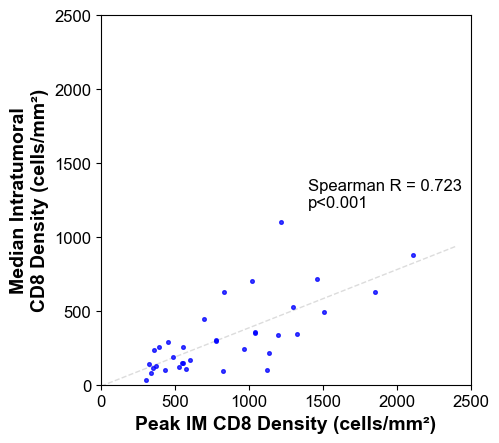

In [54]:
plt.scatter(peak_im, intratum, s=7, color="blue", alpha=0.75)

plt.plot([0, 2400], [res_lin.intercept, res_lin.intercept + res_lin.slope * 2400], color="gainsboro", linewidth=1, linestyle="--", zorder=0)

plt.text(1400, 1200, f"Spearman R = {res.correlation:.3f}\np<0.001", fontdict={"fontsize": 12, "fontname": "Arial"})

plt.xlabel("Peak IM CD8 Density (cells/mm\u00b2)", fontdict=font_dict)
plt.ylabel("Median Intratumoral\nCD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.xticks(fontname="Arial", fontsize=12);
plt.yticks(fontname="Arial", fontsize=12);

plt.xlim(0, 2500)
plt.ylim(0, 2500)

plt.gca().set_aspect("equal")

plt.savefig("../../../../Data/Plots/DenHist/peakim_vs_intratumoral_den.png", dpi=600, transparent=True, bbox_inches="tight")

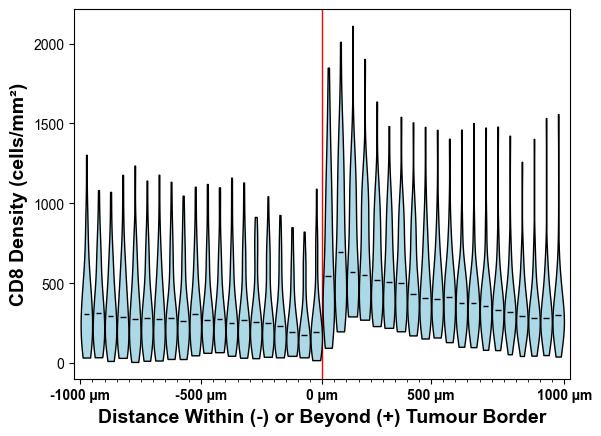

In [18]:
for idx, dist in enumerate(cohort_hist["tdist_bin"].unique()):

    subset = cohort_hist[cohort_hist["tdist_bin"] == dist].reset_index(drop=True)

    pos = idx + 0.5

    vp = plt.violinplot(
        [subset["den"].dropna().values],  # list-of-arrays
        positions=[pos],
        widths=0.95,
        showmedians=True,
        showextrema=False,
        showmeans=False
    )

    # Fill + edge styling
    for b in vp["bodies"]:
        b.set_facecolor("lightblue")
        b.set_edgecolor("black")
        b.set_alpha(1)

    # Median styling
    vp["cmedians"].set_color("black")
    vp["cmedians"].set_linewidth(1)

plt.xlim(-0.5, len(cohort_hist["tdist_bin"].unique()) + 0.5)

plt.axvline(20, color="red", linewidth=1, zorder=0)

plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(fontname="Arial")

xticks = np.arange(
    (min(cohort_hist["tdist_bin"].unique()) // 500) * 500,
    ((max(cohort_hist["tdist_bin"].unique()) + 1000) // 500) * 500,
    500
);

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.xticks([-0, 10, 20, 29, 40],
           labels=[f"{int(tick)} \u00B5m" for tick in xticks],
           fontname="Arial", fontweight="bold");

plt.savefig(
    f"../../../../Data/Plots/DenHist/cohort_den_hist_violinplot.png",
    dpi=600, bbox_inches="tight", transparent=True
)

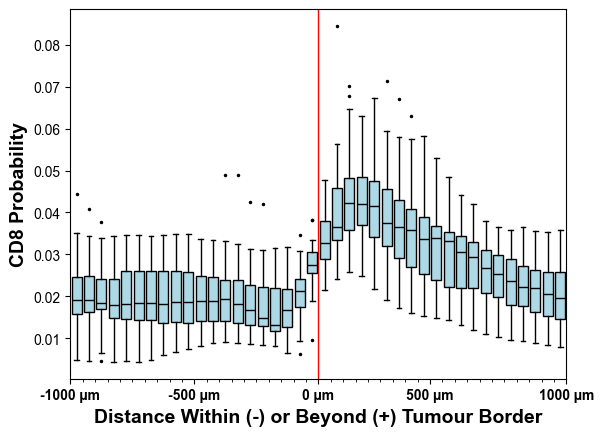

In [54]:
for idx, dist in enumerate(cohort_hist["tdist_bin"].unique()):

    subset = cohort_hist[cohort_hist["tdist_bin"] == dist].reset_index(drop=True)

    idx += 0.5

    plt.boxplot(subset["smoothed_prob"], positions=[idx], widths=0.8, flierprops={"marker": ".", "markerfacecolor": "black", "markersize": 3}, medianprops={"color": "black", "linewidth": 1}, patch_artist=True, boxprops={"facecolor": "lightblue"})

plt.axvline(20, color="red", linewidth=1, zorder=0)

plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
plt.ylabel("CD8 Probability", fontdict=font_dict)

plt.yticks(fontname="Arial");

xticks = np.arange((min(cohort_hist["tdist_bin"].unique()) // 500) * 500, ((max(cohort_hist["tdist_bin"].unique()) + 1000) // 500) * 500, 500)

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
# plt.gca().tick_params(which="minor", width=2, length=3)

plt.xticks([-0, 10, 20, 29, 40], labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold");

plt.savefig(f"../../../../Data/Plots/ProbHist/cohort_prob_hist_boxplot.png", dpi=600, bbox_inches="tight", transparent=True)

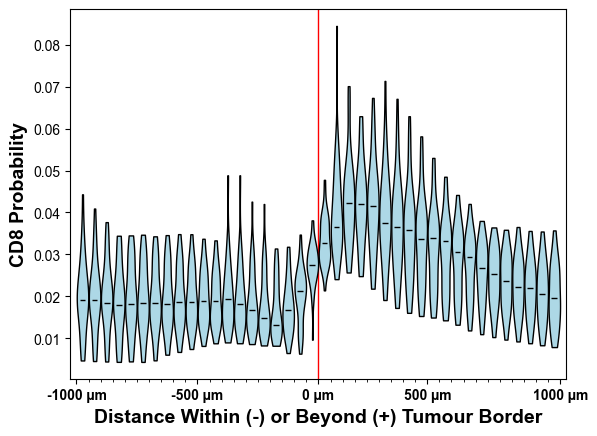

In [64]:
for idx, dist in enumerate(cohort_hist["tdist_bin"].unique()):

    subset = cohort_hist[cohort_hist["tdist_bin"] == dist].reset_index(drop=True)

    pos = idx + 0.5

    vp = plt.violinplot(
        [subset["smoothed_prob"].dropna().values],  # list-of-arrays
        positions=[pos],
        widths=0.95,
        showmedians=True,
        showextrema=False,   # similar vibe to your boxplot styling
        showmeans=False
    )

    # Fill + edge styling
    for b in vp["bodies"]:
        b.set_facecolor("lightblue")
        b.set_edgecolor("black")
        b.set_alpha(1)

    # Median styling
    vp["cmedians"].set_color("black")
    vp["cmedians"].set_linewidth(1)

plt.xlim(-0.5, len(cohort_hist["tdist_bin"].unique()) + 0.5)

plt.axvline(20, color="red", linewidth=1, zorder=0)

plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
plt.ylabel("CD8 Probability", fontdict=font_dict)

plt.yticks(fontname="Arial")

xticks = np.arange(
    (min(cohort_hist["tdist_bin"].unique()) // 500) * 500,
    ((max(cohort_hist["tdist_bin"].unique()) + 1000) // 500) * 500,
    500
);

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.xticks([-0, 10, 20, 29, 40],
           labels=[f"{int(tick)} \u00B5m" for tick in xticks],
           fontname="Arial", fontweight="bold");

plt.savefig(
    f"../../../../Data/Plots/ProbHist/cohort_prob_hist_violinplot.png",
    dpi=600, bbox_inches="tight", transparent=True
)

In [26]:
cohort_mean = cohort_hist.groupby("tdist_bin")["prob"].mean().reset_index()

cohort_mean["prob"] = cohort_mean["prob"] / cohort_mean["prob"].sum()

cohort_median = cohort_hist.groupby("tdist_bin")["prob"].median().reset_index()

In [32]:
tum_mean = cohort_mean[cohort_mean["tdist_bin"] < 0]["prob"].mean()

tum_std = cohort_mean[cohort_mean["tdist_bin"] < 0]["prob"].std()

tum_med = cohort_median[cohort_median["tdist_bin"] < 0]["prob"].median()

cohort_mean["norm"] = (cohort_mean["prob"] - tum_mean) / tum_std

cohort_mean["norm_med"] = (cohort_mean["prob"] - tum_med) / tum_std

In [23]:
data_x = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
data_y = []
data_diff = []
for x in data_x:

    y = cohort_mean[(cohort_mean["tdist_bin"] > -50) & (cohort_mean["tdist_bin"] < x)]["prob"].sum()

    y_last = cohort_mean[(cohort_mean["tdist_bin"] > -50) & (cohort_mean["tdist_bin"] < x - 50)]["prob"].sum()

    y_diff = y - y_last

    data_y.append(y)
    data_diff.append(y_diff)

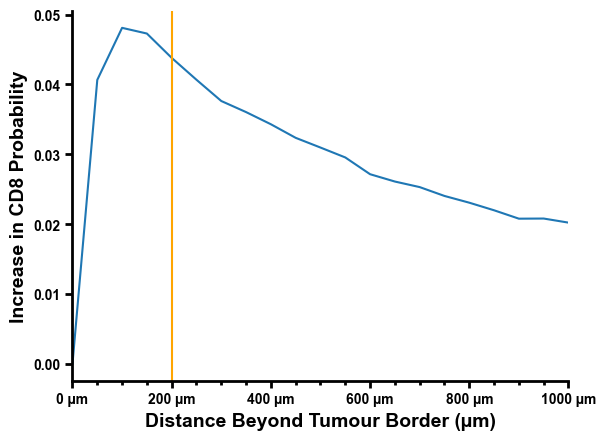

In [24]:
plt.plot(data_x, data_diff)

plt.xlabel("Distance Beyond Tumour Border (\u00B5m)", fontdict=font_dict)
plt.ylabel("Increase in CD8 Probability", fontdict=font_dict)

plt.axvline(200, color="orange", linestyle="-")

plt.yticks(fontname="Arial", fontweight="bold")

xticks = np.arange((min(data_x) // 200) * 200, ((max(data_x) + 1000) // 200) * 200, 200)

plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().tick_params(which="minor", width=2, length=3)

plt.gca().tick_params(width=2, length=5)

plt.yticks(fontname="Arial")

plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xlim(0, 1000)

plt.savefig(f"../../../../Data/Plots/ProbHist/cohort_cd8_prob_increase.png", dpi=600)

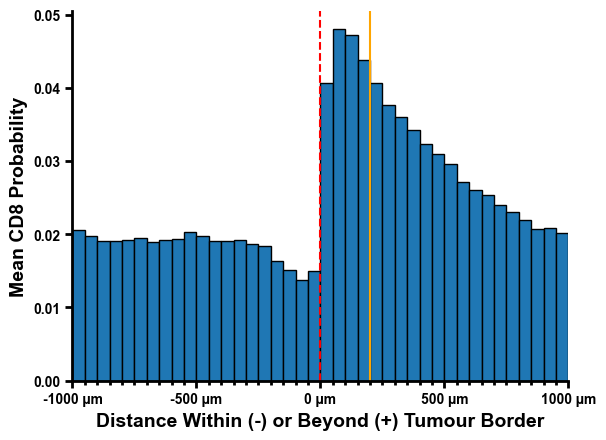

In [25]:
plt.bar(cohort_mean["tdist_bin"], cohort_mean["prob"], width=50, edgecolor="black", align="edge")

# plt.ylim(-1.5, 6)

plt.axvline(0, color="red", linestyle="--")

plt.axvline(200, color="orange", linestyle="-")

plt.ylabel("Mean CD8 Probability", fontdict=font_dict)

plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)

plt.yticks(fontname="Arial", fontweight="bold")

xticks = np.arange((min(cohort_mean["tdist_bin"]) // 500) * 500, ((max(cohort_mean["tdist_bin"]) + 1000) // 500) * 500, 500)

plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().tick_params(which="minor", width=2, length=3)

plt.gca().tick_params(width=2, length=5)

plt.yticks(fontname="Arial")

plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xlim(-1000, 1000)

plt.savefig(f"../../../../Data/Plots/ProbHist/total_prob_mean_cropped.png", dpi=600, transparent=True)

In [36]:
x = 0.2827
y = 0.7854
z = 3.1416

In [41]:
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:

    res_x = n * x / 173.6527 * 100
    res_y = n * y / 173.6527 * 100
    res_z = n * z / 173.6527 * 100

    print(f"{n}: {res_x:.2f}, {res_y:.2f}, {res_z:.2f}")

1: 0.16, 0.45, 1.81
2: 0.33, 0.90, 3.62
3: 0.49, 1.36, 5.43
4: 0.65, 1.81, 7.24
5: 0.81, 2.26, 9.05
6: 0.98, 2.71, 10.85
7: 1.14, 3.17, 12.66
8: 1.30, 3.62, 14.47
9: 1.47, 4.07, 16.28
10: 1.63, 4.52, 18.09


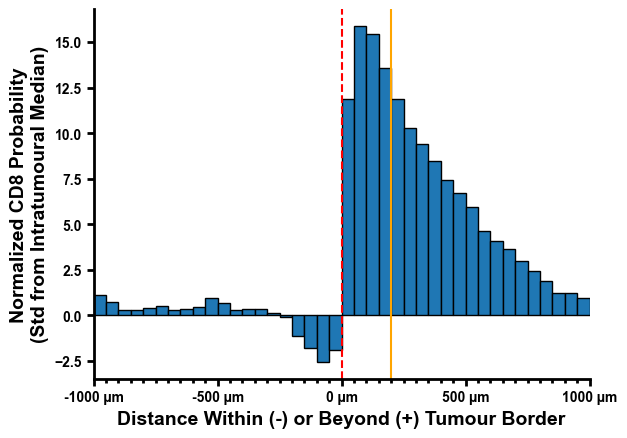

In [33]:
plt.bar(cohort_mean["tdist_bin"], cohort_mean["norm_med"], width=50, edgecolor="black", align="edge")

# plt.ylim(-1.5, 6)

plt.axvline(0, color="red", linestyle="--")

plt.axvline(200, color="orange", linestyle="-")

plt.ylabel("Normalized CD8 Probability\n(Std from Intratumoural Median)", fontdict=font_dict)

plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)

plt.yticks(fontname="Arial", fontweight="bold")

xticks = np.arange((min(cohort_mean["tdist_bin"]) // 500) * 500, ((max(cohort_mean["tdist_bin"]) + 1000) // 500) * 500, 500)

plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().tick_params(which="minor", width=2, length=3)

plt.gca().tick_params(width=2, length=5)

plt.yticks(fontname="Arial")

plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xlim(-1000, 1000)

plt.savefig(f"../../../../Data/Plots/ProbHist/total_prob_norm_median_cropped.png", dpi=600, bbox_inches="tight", transparent=True)

# Get Probability Distribution for Overall Cohort

In [5]:
# Overall Cohort
cohort_hist = pd.read_excel("../../../../Data/cohort_hist_data.xlsx")

cohort_total = cohort_hist.groupby("tdist_bin").sum()[["count", "area"]].reset_index()
cohort_total["den"] = cohort_total["count"] / cohort_total["area"]
cohort_total["prob"] = cohort_total["count"] / cohort_total["count"].sum() / (cohort_total["area"] / cohort_total["area"].sum())
cohort_total["prob"] = cohort_total["prob"] / cohort_total["prob"].sum()

lowess_result = lowess(cohort_total["prob"], cohort_total["tdist_bin"], frac=0.2)
cohort_total["smoothed_prob"] = np.interp(cohort_total["tdist_bin"], lowess_result[:, 0], lowess_result[:, 1])

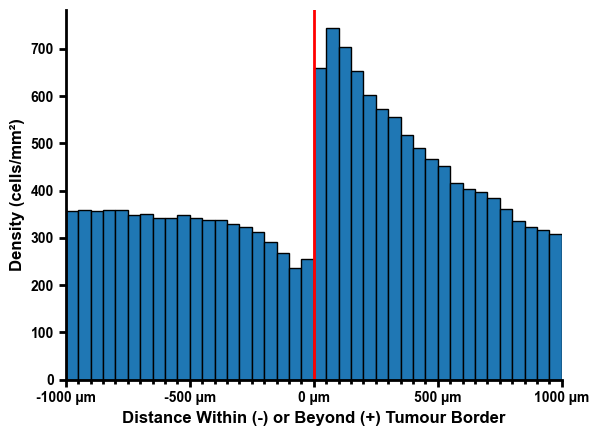

In [62]:
intratum_mean = cohort_total[cohort_total["tdist_bin"] < 0]["den"].mean()
intratum_std = cohort_total[cohort_total["tdist_bin"] < 0]["den"].std()

plt.bar(cohort_total["tdist_bin"], cohort_total["den"], width=50, edgecolor="black", align="edge")
plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
plt.ylabel("Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(fontname="Arial", fontweight="bold")

xticks = np.arange((min(cohort_total["tdist_bin"]) // 500) * 500, ((max(cohort_total["tdist_bin"]) + 1000) // 500) * 500, 500)

plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().tick_params(which="minor", width=2, length=3)

plt.gca().tick_params(width=2, length=5)

plt.xlim(-1000, 1000)

# plt.ylim(-2.5, 6)

plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(0, color="red", linewidth=2)

# plt.savefig(f"../../../../Data/Plots/ProbHist/total_prob_hist_cropped.png", dpi=600)

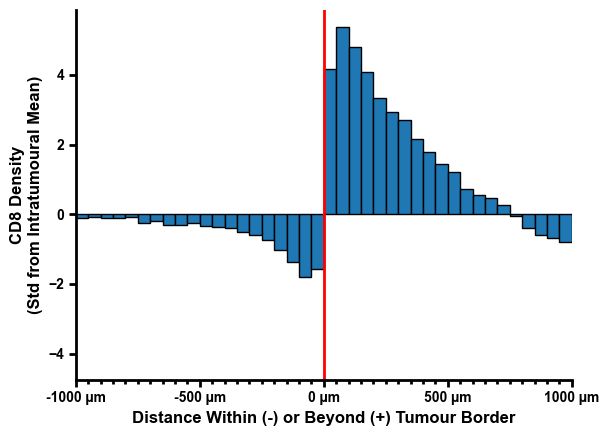

In [10]:
intratum_mean = cohort_total[cohort_total["tdist_bin"] < 0]["den"].mean()
intratum_std = cohort_total[cohort_total["tdist_bin"] < 0]["den"].std()

plt.bar(cohort_total["tdist_bin"], (cohort_total["den"] - intratum_mean) / intratum_std, width=50, edgecolor="black", align="edge")
plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
plt.ylabel("CD8 Density\n(Std from Intratumoural Mean)", fontdict=font_dict)

plt.yticks(fontname="Arial", fontweight="bold")

xticks = np.arange((min(cohort_total["tdist_bin"]) // 500) * 500, ((max(cohort_total["tdist_bin"]) + 1000) // 500) * 500, 500)

plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().tick_params(which="minor", width=2, length=3)

plt.gca().tick_params(width=2, length=5)

plt.xlim(-1000, 1000)

# plt.ylim(-2.5, 6)

plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(0, color="red", linewidth=2)

# plt.savefig(f"../../../../Data/Plots/ProbHist/total_prob_hist_cropped.png", dpi=600)

In [ ]:
cohort_hist = pd.read_excel("../../../../Data/cohort_hist_data.xlsx")

# Replicating Original Density Distribution

In [6]:
hist_list = []

for sampleid in cohort_hist["sampleid"].unique():
    sample_hist = cohort_hist[cohort_hist["sampleid"] == sampleid]

    tum_mean = sample_hist[sample_hist["tdist_bin"] < 0]["den"].mean()
    tum_std = sample_hist[sample_hist["tdist_bin"] < 0]["den"].std()

    sample_hist["den_std"] = (sample_hist["den"] - tum_mean) / tum_std

    hist_list.append(sample_hist)

hist_df = pd.concat(hist_list)

C:\Users\Michael\AppData\Local\Temp\ipykernel_29092\2115662835.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_hist["den_std"] = (sample_hist["den"] - tum_mean) / tum_std
C:\Users\Michael\AppData\Local\Temp\ipykernel_29092\2115662835.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_hist["den_std"] = (sample_hist["den"] - tum_mean) / tum_std
C:\Users\Michael\AppData\Local\Temp\ipykernel_29092\2115662835.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [7]:
cohort_mean = hist_df.groupby("tdist_bin")["den_std"].mean().reset_index()

cohort_median = hist_df.groupby("tdist_bin")["den_std"].median().reset_index()

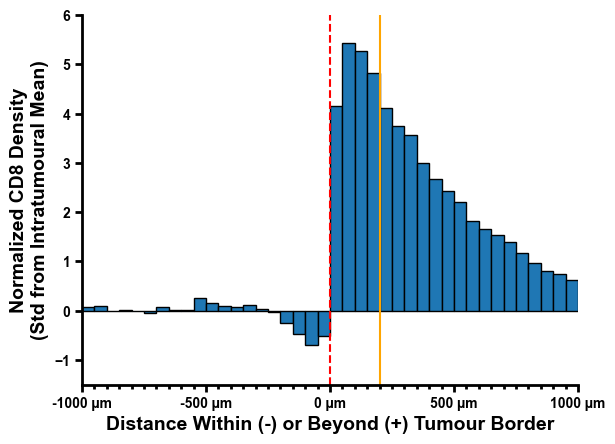

In [8]:
plt.bar(cohort_mean["tdist_bin"], cohort_mean["den_std"], width=50, edgecolor="black", align="edge")

plt.ylim(-1.5, 6)

plt.axvline(0, color="red", linestyle="--")

plt.axvline(200, color="orange", linestyle="-")

plt.ylabel("Normalized CD8 Density\n(Std from Intratumoural Mean)", fontdict=font_dict)

plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)

plt.yticks(fontname="Arial", fontweight="bold")

xticks = np.arange((min(cohort_total["tdist_bin"]) // 500) * 500, ((max(cohort_total["tdist_bin"]) + 1000) // 500) * 500, 500)

plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().tick_params(which="minor", width=2, length=3)

plt.gca().tick_params(width=2, length=5)

plt.yticks(fontname="Arial")

plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xlim(-1000, 1000)

plt.savefig("Mean_CD8_Density_Dist.png", dpi=900, bbox_inches="tight", transparent=True)

In [22]:
outer_mean = cohort_mean[cohort_mean["tdist_bin"] > -50]

In [23]:
outer_mean

,tdist_bin,den_std
125,0,4.158801
126,50,5.429606
127,100,5.261960
128,150,4.817110
129,200,4.121143
130,250,3.744470
131,300,3.571121
132,350,2.989819
133,400,2.680497
134,450,2.433695


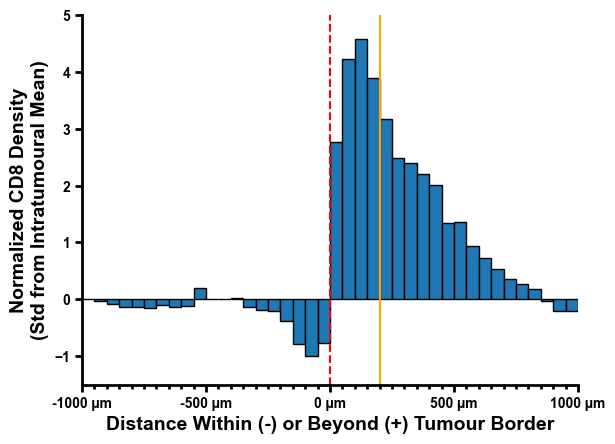

In [9]:
plt.bar(cohort_median["tdist_bin"], cohort_median["den_std"], width=50, edgecolor="black", align="edge")

plt.ylim(-1.5, 5)

plt.axvline(0, color="red", linestyle="--")

plt.axvline(200, color="orange", linestyle="-")

plt.ylabel("Normalized CD8 Density\n(Std from Intratumoural Mean)", fontdict=font_dict)

plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)

plt.yticks(fontname="Arial", fontweight="bold")

xticks = np.arange((min(cohort_total["tdist_bin"]) // 500) * 500, ((max(cohort_total["tdist_bin"]) + 1000) // 500) * 500, 500)

plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().tick_params(which="minor", width=2, length=3)

plt.gca().tick_params(width=2, length=5)

plt.yticks(fontname="Arial")

plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xlim(-1000, 1000)

plt.savefig("Median_CD8_Density_Dist.png", dpi=900, bbox_inches="tight", transparent=True)